<a href="https://colab.research.google.com/github/esemsc-ald24/environments_mpm/blob/master/Example_data_downloading_and_exploration_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2024-25-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.h5:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

In [ ]:
import pandas as pd
import numpy as np
import h5py
import IPython
import PIL
import matplotlib.pyplot as plt
import os
import io
from itertools import islice
from tqdm import tqdm
import numpy as np
import glob
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [ ]:
# this DataFrame contains all of the event meta data
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
df

,id,img_type,start_utc,llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon,proj,height_m,width_m
0,S778114,ir069,2018-08-20 19:50:00+00:00,32.781533,-92.631841,35.944590,-88.134075,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
1,S778114,ir107,2018-08-20 19:50:00+00:00,32.781533,-92.631841,35.944590,-88.134075,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
2,S778114,lght,NaT,32.781533,-92.631841,35.944590,-88.134075,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
3,S778114,vil,2018-08-20 19:50:00+00:00,32.781533,-92.631841,35.944590,-88.134075,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
4,S778114,vis,2018-08-20 19:50:00+00:00,32.781533,-92.631841,35.944590,-88.134075,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
...,...,...,...,...,...,...,...,...,...,...
3995,S832818,ir069,2019-07-28 17:44:00+00:00,46.493514,-100.371384,49.953392,-95.191216,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
3996,S832818,ir107,2019-07-28 17:44:00+00:00,46.493514,-100.371384,49.953392,-95.191216,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
3997,S832818,lght,NaT,46.493514,-100.371384,49.953392,-95.191216,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0
3998,S832818,vil,2019-07-28 17:45:00+00:00,46.493514,-100.371384,49.953392,-95.191216,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384000.0,384000.0


In [ ]:
print(f"Total number of events: {len(df.id.unique())}")

Total number of events: 800


In [ ]:
# this function loads all of the image arrays for a given id
def load_event(id):
    "Load event"
    with h5py.File(f'data/train.h5','r') as f:
        event = {img_type: f[id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil', 'lght']}
    return event

event = load_event("S778114")
for img_type in event:
    print(f"{img_type}: {event[img_type].shape} ({event[img_type].dtype})")

vis: (384, 384, 36) (int16)
ir069: (192, 192, 36) (int16)
ir107: (192, 192, 36) (int16)
vil: (384, 384, 36) (uint8)
lght: (38777, 5) (float32)


In [ ]:
# Let's look at the lightning data for an event
pd.DataFrame(data=event["lght"], columns=["t", "lat (deg)", "lon (deg)", "vil pixel x", "vil pixel y"]).sort_values("t")

,t,lat (deg),lon (deg),vil pixel x,vil pixel y
0,0.0,35.221024,-91.398697,97.144623,277.964905
1,0.0,35.011932,-91.927162,50.720562,251.529099
2,0.0,35.162552,-91.867744,55.068687,268.602295
3,0.0,34.954666,-92.266518,20.261250,243.241348
4,1.0,33.350700,-91.901527,64.372375,67.255501
...,...,...,...,...,...
38772,10789.0,34.324982,-91.087601,132.307999,180.527847
38771,10789.0,33.844326,-89.936607,241.919693,135.542786
38770,10789.0,34.804821,-90.910904,144.651932,234.979279
38776,10799.0,33.544811,-91.005325,145.910568,94.501938


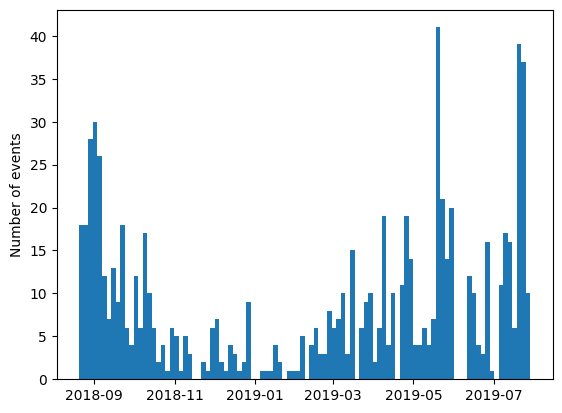

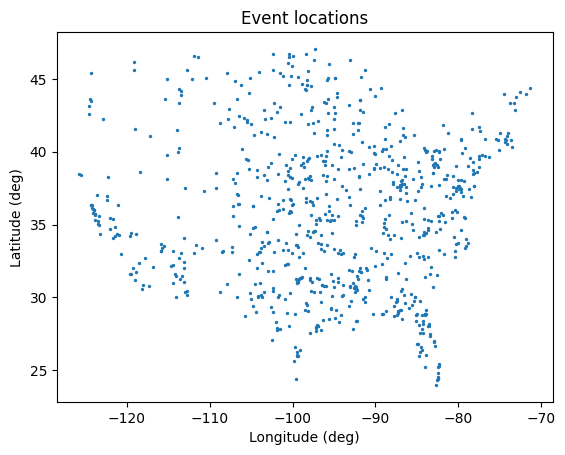

In [ ]:
# let's plot some meta data histograms!

# plot times
plt.hist(df[df.img_type=="vil"].start_utc.dt.tz_localize(None), bins=100)
plt.ylabel("Number of events")
plt.show()

# plot positions
plt.title("Event locations")
plt.scatter(df[df.img_type=="vil"].llcrnrlon, df[df.img_type=="vil"].llcrnrlat, s=2)
plt.xlabel("Longitude (deg)"); plt.ylabel("Latitude (deg)")
plt.show()

In [ ]:
# 假设你的 DataFrame 变量名是 df
ids = df['id'].unique().tolist()

# 打印唯一的 ID 列表
print(ids)

['S778114', 'S767475', 'S771210', 'S782022', 'S769788', 'S782134', 'S780339', 'S780175', 'S769599', 'S780322', 'S779978', 'S779481', 'S786332', 'S768254', 'S780325', 'S772799', 'S781628', 'S772454', 'S781919', 'S770037', 'S777654', 'S786356', 'S779509', 'S771097', 'S786359', 'S783140', 'S769394', 'S772029', 'S770056', 'S781525', 'S778991', 'S769170', 'S786445', 'S785820', 'S782631', 'S769250', 'S772400', 'S775278', 'S771100', 'S772429', 'S782637', 'S779911', 'S773275', 'S772050', 'S778397', 'S783217', 'S782378', 'S779250', 'S785834', 'S779890', 'S779041', 'S780772', 'S771044', 'S777831', 'S778665', 'S780190', 'S772556', 'S786034', 'S782326', 'S780798', 'S781977', 'S782114', 'S771220', 'S779990', 'S780823', 'S772435', 'S773328', 'S771395', 'S777840', 'S772083', 'S781453', 'S771950', 'S779050', 'S779396', 'S777899', 'S779430', 'S779848', 'S786015', 'S785304', 'S785662', 'S777884', 'S786690', 'S774361', 'S779553', 'S786459', 'S785385', 'S772041', 'S787572', 'S787107', 'S785959', 'S778000'

In [ ]:
import h5py
import numpy as np
from scipy.ndimage import zoom

def preprocess_normalization(file_path, id, target_size=(384, 384)):
    with h5py.File(file_path, 'r') as f:
        event_data = {}
        for key in ['vis', 'ir069', 'ir107', 'vil']:
            raw_data = f[id][key][:]

            # Step 1: Min-Max
            normalized_data = np.array([
                (frame - np.min(frame)) / (np.max(frame) - np.min(frame) + 1e-6)
                for frame in raw_data
            ])

            # Step 2:(Upscale)
            scale = (target_size[0] / normalized_data.shape[0],
                     target_size[1] / normalized_data.shape[1],
                     1)
            upscaled_data = zoom(normalized_data, scale, order=1)

            event_data[key] = upscaled_data

    return event_data

In [ ]:
import random
part_ids = random.sample(ids, 80)

print(f"选出的 ID: {part_ids}")

选出的 ID: ['S784389', 'S785499', 'S783901', 'S786755', 'S781919', 'S772556', 'S788760', 'S782378', 'S788666', 'S772400', 'S809079', 'S786188', 'S818644', 'S778450', 'S844588', 'S801234', 'S827374', 'S838867', 'S838591', 'S819119', 'S836039', 'S819464', 'S808425', 'S844166', 'S810149', 'S821043', 'S828585', 'S844663', 'S808479', 'S770037', 'S774122', 'S845424', 'S845117', 'S841230', 'S778798', 'S829989', 'S788040', 'S783898', 'S813016', 'S853732', 'S791311', 'S772429', 'S848164', 'S836870', 'S824150', 'S771950', 'S788338', 'S786979', 'S781977', 'S845947', 'S845995', 'S836880', 'S786228', 'S816678', 'S845084', 'S841285', 'S846450', 'S826087', 'S780339', 'S791686', 'S803568', 'S843957', 'S773261', 'S775444', 'S777831', 'S783949', 'S777899', 'S847426', 'S826665', 'S808730', 'S824382', 'S790271', 'S813512', 'S779430', 'S807481', 'S784296', 'S844704', 'S843743', 'S813299', 'S830300']


In [ ]:
def batch(iterable, n=1):
    """生成批次的辅助函数"""
    iterable = iter(iterable)
    while True:
        batch = list(islice(iterable, n))
        if not batch:
            break
        yield batch

def process_and_save_in_batches(file_path, ids, output_dir, batch_size=10, target_size=(384, 384)):
    """
    分批处理数据。
    """
    for batch_ids in tqdm(batch(ids, batch_size), desc="Processing Batches"):
        for id in batch_ids:
            processed_event = preprocess_normalization(file_path, id, target_size)
            np.save(f"{output_dir}/{id}.npy", processed_event)

# 示例使用
if __name__ == "__main__":
    file_path = 'data/train.h5'
    output_dir = 'processed_data'
    os.makedirs(output_dir)
    process_and_save_in_batches(file_path, part_ids, output_dir, batch_size=20)

Processing Batches: 4it [02:23, 35.81s/it]


In [ ]:
import glob
import os
import random

data_dir = "processed_data"
all_files = sorted(glob.glob(os.path.join(data_dir, "*.npy")))

# 假设前64个用于训练，后16个用于验证
train_files = all_files[:64]
val_files   = all_files[64:]


In [ ]:
import numpy as np

def data_generator(file_list, batch_size=8, shuffle=True):

    while True:  # 让生成器在 fit 时不断产生数据
        if shuffle:
            random.shuffle(file_list)  # 每个 epoch 都对文件列表洗牌

        for fpath in file_list:
            data_dict = np.load(fpath, allow_pickle=True).item()

            vis_data   = data_dict['vis']   # (384,384,36)
            ir069_data = data_dict['ir069'] # (384,384,36)
            ir107_data = data_dict['ir107'] # (384,384,36)
            vil_data   = data_dict['vil']   # (384,384,36)

            # 将36个时刻的帧先收集在 frames 列表
            frames = []
            t_size = vis_data.shape[-1]  # =36
            for t in range(t_size):
                x_frame = np.stack([
                    vis_data[:, :, t],
                    ir069_data[:, :, t],
                    ir107_data[:, :, t]
                ], axis=-1)  # (384,384,3)
                y_frame = vil_data[:, :, t]     # (384,384)
                frames.append((x_frame, y_frame))

            # 如果希望每个文件内也打乱时刻顺序，可以 shuffle
            if shuffle:
                random.shuffle(frames)

            # 按 batch_size 产出
            for i in range(0, len(frames), batch_size):
                batch_frames = frames[i:i+batch_size]

                # 把 X, Y 分别组合起来
                X_batch = np.array([bf[0] for bf in batch_frames], dtype=np.float32)
                Y_batch = np.array([bf[1] for bf in batch_frames], dtype=np.float32)

                # Y 扩一维变成 (batch_size, 384, 384, 1)
                Y_batch = np.expand_dims(Y_batch, axis=-1)

                yield (X_batch, Y_batch)


In [ ]:
train_steps = (len(train_files) * 36) // 8  # = 2304 // 8 = 288
val_steps   = (len(val_files)   * 36) // 8  # = 576  // 8 = 72

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def small_unet_model(input_shape=(384, 384, 3)):
    inputs = keras.Input(shape=input_shape)

    # 下采样部分 (Encoder)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    # 上采样部分 (Decoder)
    u5 = layers.UpSampling2D(size=(2, 2))(c4)
    u5 = layers.concatenate([u5, c3], axis=-1)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D(size=(2, 2))(c5)
    u6 = layers.concatenate([u6, c2], axis=-1)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D(size=(2, 2))(c6)
    u7 = layers.concatenate([u7, c1], axis=-1)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(c7)

    # 最后一层用 1 个通道表示输出 (vil)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)
    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

model = small_unet_model()
# model.summary()
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='mae',
    metrics=['mae']
)

In [ ]:
# 建立生成器
batch_size = 8
train_gen = data_generator(train_files, batch_size=batch_size, shuffle=True)
val_gen   = data_generator(val_files,   batch_size=batch_size, shuffle=False)

history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=8,
    validation_data=val_gen,
    validation_steps=val_steps
)


Epoch 1/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - loss: 0.1837 - mae: 0.1837 - val_loss: 0.0871 - val_mae: 0.0871
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - loss: 0.1166 - mae: 0.1166 - val_loss: 0.0827 - val_mae: 0.0827
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.0986 - mae: 0.0986 - val_loss: 0.0729 - val_mae: 0.0729
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - loss: 0.1003 - mae: 0.1003 - val_loss: 0.0833 - val_mae: 0.0833
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - loss: 0.0970 - mae: 0.0970 - val_loss: 0.0785 - val_mae: 0.0785
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - loss: 0.0894 - mae: 0.0894 - val_loss: 0.0731 - val_mae: 0.0731
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - loss: 0.0921 - mae: 0.0921 - val_loss: 0.0783 - val_mae: 0.0783
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 25s 86ms/step - loss: 0.0890 - mae: 0.0890 - val_loss: 0.0796 - val_mae: 0.0796
Epoch 9/20
288/288 ━━━━━━━━━━━━━━━━━━

In [ ]:
# import numpy as np
# import glob
# import os

# data_dir = 'processed_data'  # 存放 .npy 文件的目录
# file_list = sorted(glob.glob(os.path.join(data_dir, '*.npy')))

# X_list = []
# Y_list = []

# for fpath in file_list:
#     # 加载并取出其中的 Python 字典
#     data_dict = np.load(fpath, allow_pickle=True).item()
#     # 分别取出四个通道
#     vis_data   = data_dict['vis']   # shape: (384, 384, 36)
#     ir069_data = data_dict['ir069'] # shape: (384, 384, 36)
#     ir107_data = data_dict['ir107'] # shape: (384, 384, 36)
#     vil_data   = data_dict['vil']   # shape: (384, 384, 36)

#     # T=36个时刻，每一帧单独作为一条训练数据
#     for t in range(vis_data.shape[-1]):
#         vis_frame   = vis_data[:, :, t]   # (384, 384)
#         ir069_frame = ir069_data[:, :, t] # (384, 384)
#         ir107_frame = ir107_data[:, :, t] # (384, 384)
#         vil_frame   = vil_data[:, :, t]   # (384, 384)

#         # 把三个输入通道拼起来作为 X
#         # shape: (384, 384, 3)
#         x = np.stack([vis_frame, ir069_frame, ir107_frame], axis=-1)

#         # 把 vil_frame 作为要预测的目标 y
#         # shape: (384, 384)
#         y = vil_frame

#         X_list.append(x)
#         Y_list.append(y)

# # 拼接成 numpy array，方便后续送入神经网络
# X = np.array(X_list, dtype=np.float32)  # shape: (N, 384, 384, 3)
# Y = np.array(Y_list, dtype=np.float32)  # shape: (N, 384, 384)

# print('X shape:', X.shape)
# print('Y shape:', Y.shape)


In [ ]:
# from sklearn.model_selection import train_test_split

# # 训练集/验证集拆分，比如 8:2
# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# # 注意：Y 的 shape 需要是 (batch, 384, 384, 1) 才能跟网络输出对应
# Y_train = np.expand_dims(Y_train, axis=-1)
# Y_val   = np.expand_dims(Y_val,   axis=-1)

# history = model.fit(
#     X_train, Y_train,
#     validation_data=(X_val, Y_val),
#     batch_size=2,     # 依照资源适当调整；384×384 尺寸太大时可用小 batch
#     epochs=20,
#     verbose=1
# )


In [ ]:
# 假设你之前已经做好了训练/验证集拆分
# X_val shape: (N_val, 384, 384, 3)
# Y_val shape: (N_val, 384, 384, 1)  <-- 不要忘记之前我们给 vil 扩过维度

# 从验证集中随机取一条样本
# idx = np.random.randint(0, X_val.shape[0])
# x_test = X_val[idx]  # shape: (384, 384, 3)
# y_true = Y_val[idx]  # shape: (384, 384, 1)


In [ ]:
# # 扩一下 batch 维度 (1, 384, 384, 3)
# x_test_batch = np.expand_dims(x_test, axis=0)

# # 执行预测
# pred_vil = model.predict(x_test_batch)  # shape: (1, 384, 384, 1)

# # 把 batch 维度和 channel 维度去掉，拿到 (384, 384)
# pred_vil = pred_vil[0, :, :, 0]
# y_true_2d = y_true[:, :, 0]  # 同样把 channel 去掉，方便可视化


In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# axes[0].imshow(x_test[..., 0], cmap='gray')
# axes[0].set_title('Input (vis channel)')

# im1 = axes[1].imshow(pred_vil, cmap='jet')
# axes[1].set_title('Predicted VIL')
# plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# im2 = axes[2].imshow(y_true_2d, cmap='jet')
# axes[2].set_title('True VIL')
# plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# plt.tight_layout()
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 val_files 是验证文件列表，batch_size=8
val_gen = data_generator(val_files, batch_size=8, shuffle=False)

# 取出一批数据 (X_batch.shape=(8,384,384,3), Y_batch.shape=(8,384,384,1))
X_batch, Y_batch = next(val_gen)

# 模型预测
pred_batch = model.predict(X_batch)  # (8,384,384,1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


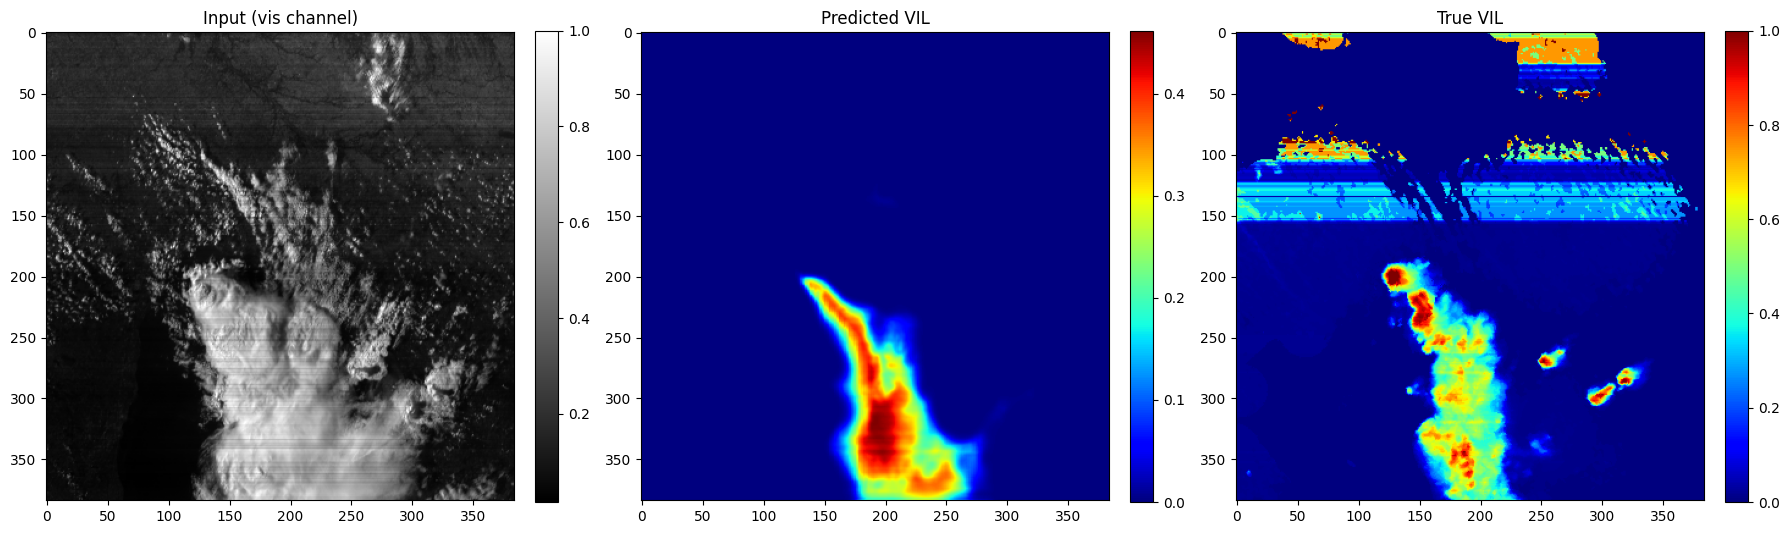

In [ ]:
# 在这个批次中随机挑一个索引
idx = np.random.randint(0, X_batch.shape[0])

# 取出第 idx 个样本
x_sample = X_batch[idx]     # shape: (384,384,3)
y_true   = Y_batch[idx]     # shape: (384,384,1)
y_pred   = pred_batch[idx]  # shape: (384,384,1)

# squeeze 通道，以便 imshow
x_vis      = x_sample[..., 0]   # 第1个通道：vis
y_true_2d  = y_true[..., 0]     # (384,384)
y_pred_2d  = y_pred[..., 0]     # (384,384)

# 画图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# (1) 输入：这里仅展示第1通道 vis
im0 = axes[0].imshow(x_vis, cmap='gray')
axes[0].set_title("Input (vis channel)")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# (2) 预测结果
im1 = axes[1].imshow(y_pred_2d, cmap='jet')
axes[1].set_title("Predicted VIL")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# (3) 真实结果
im2 = axes[2].imshow(y_true_2d, cmap='jet')
axes[2].set_title("True VIL")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


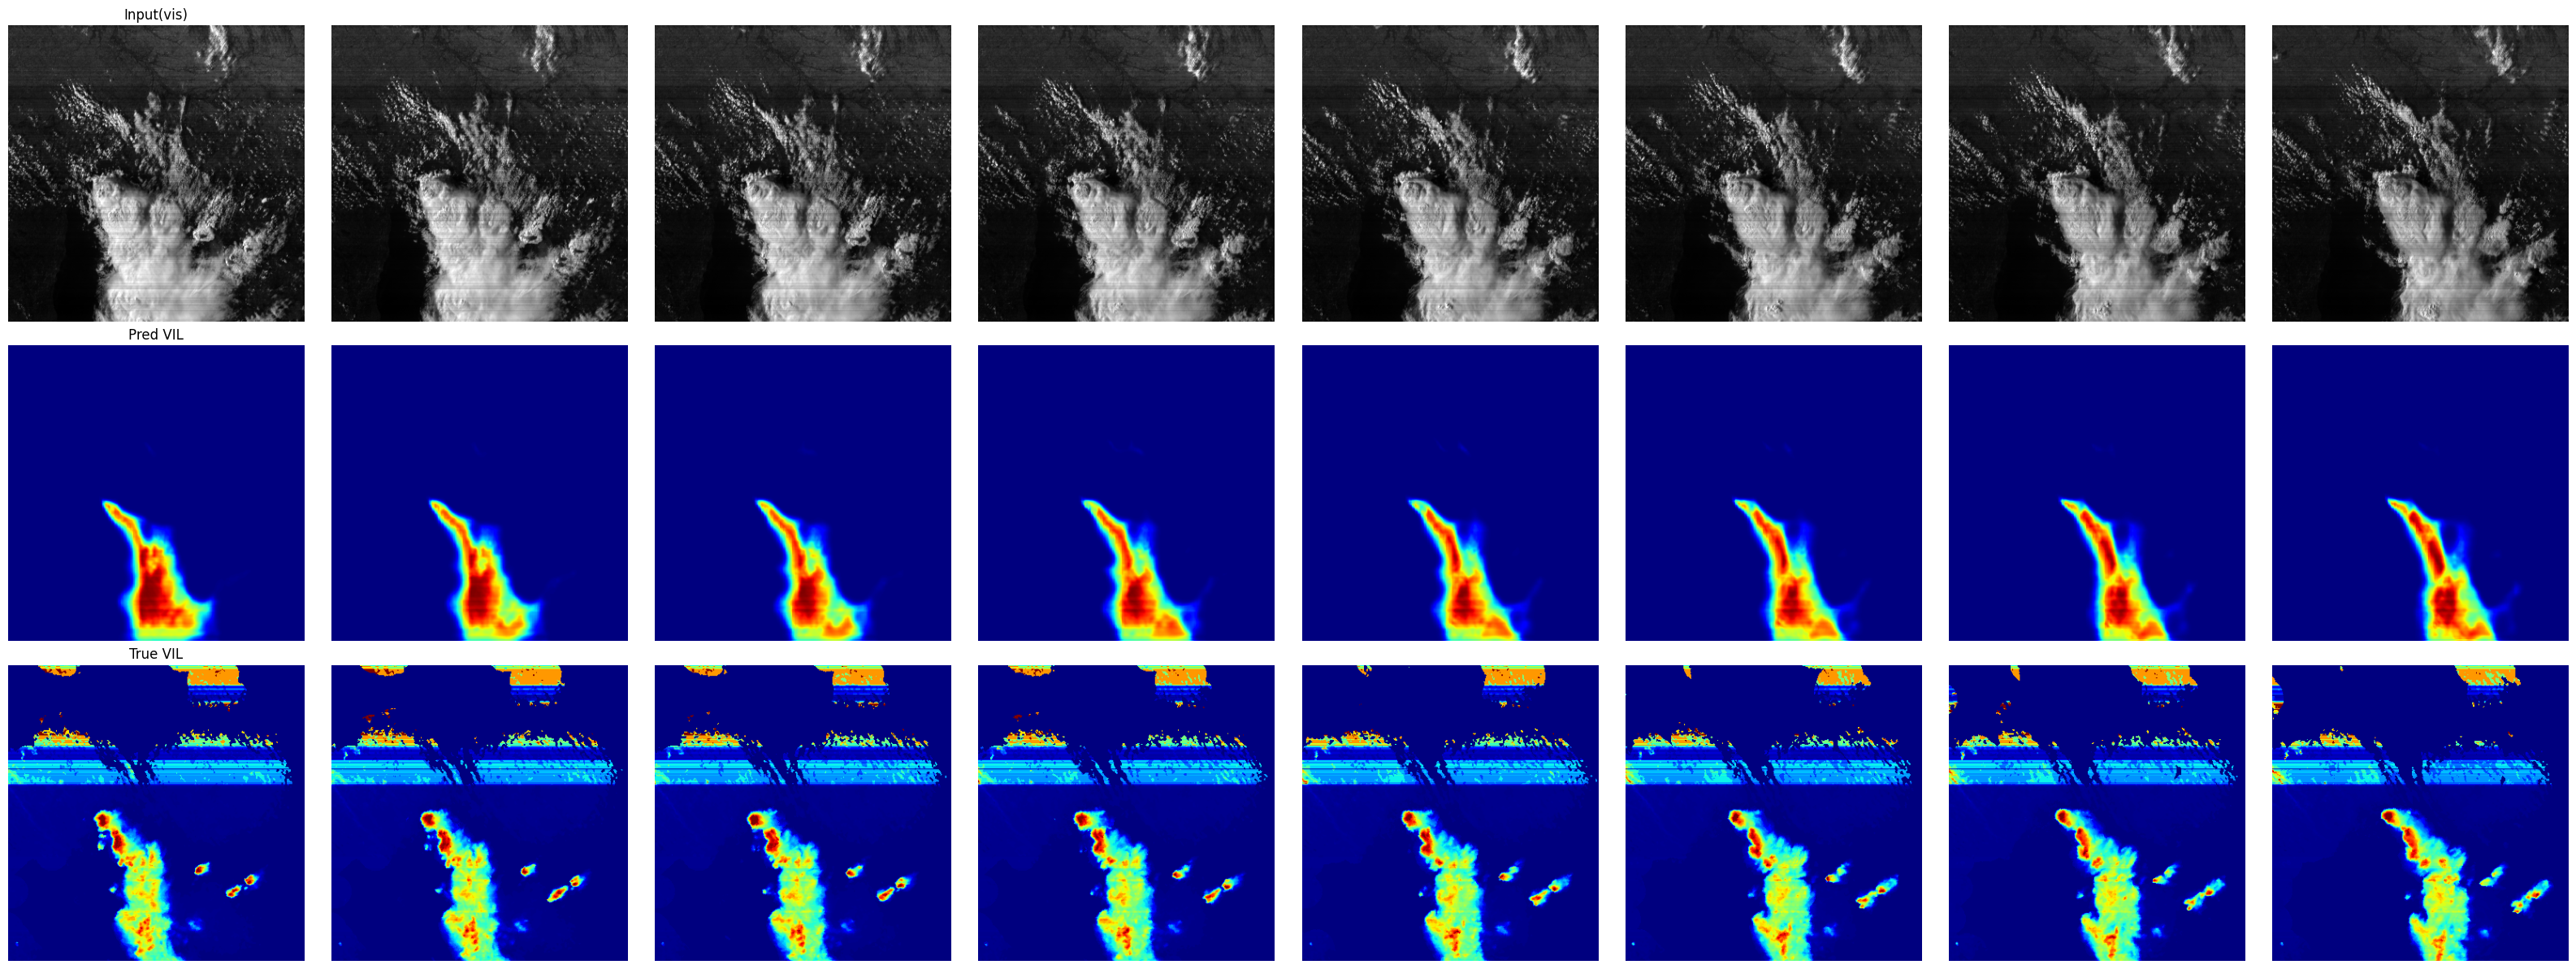

In [ ]:
n = X_batch.shape[0]  # 这里=8
plt.figure(figsize=(4*n, 12))

for i in range(n):
    x_vis_i      = X_batch[i,:,:,0]  # vis通道
    y_pred_i     = pred_batch[i,:,:,0]
    y_true_i     = Y_batch[i,:,:,0]

    # 创建3张子图，放在同一行
    plt.subplot(3, n, i+1)
    plt.imshow(x_vis_i, cmap='gray')
    plt.axis('off')
    if i == 0: plt.title("Input(vis)")

    plt.subplot(3, n, n + i+1)
    plt.imshow(y_pred_i, cmap='jet')
    plt.axis('off')
    if i == 0: plt.title("Pred VIL")

    plt.subplot(3, n, 2*n + i+1)
    plt.imshow(y_true_i, cmap='jet')
    plt.axis('off')
    if i == 0: plt.title("True VIL")

plt.tight_layout()
plt.show()

In [ ]:
import random
import numpy as np
import os
import glob
from itertools import islice
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 随机选择160个样本ID
part_ids = random.sample(ids, 160)

def batch(iterable, n=1):
    """生成批次的辅助函数"""
    iterable = iter(iterable)
    while True:
        batch = list(islice(iterable, n))
        if not batch:
            break
        yield batch

def process_and_save_in_batches(file_path, ids, output_dir, batch_size=10, target_size=(384, 384)):
    """分批处理数据"""
    for batch_ids in tqdm(batch(ids, batch_size), desc="Processing Batches"):
        for id in batch_ids:
            processed_event = preprocess_normalization(file_path, id, target_size)
            np.save(f"{output_dir}/{id}.npy", processed_event)

# 主数据处理流程
if __name__ == "__main__":
    file_path = 'data/train.h5'
    output_dir = 'processed_data'
    os.makedirs(output_dir, exist_ok=True)
    process_and_save_in_batches(file_path, part_ids, output_dir, batch_size=20)

# 准备数据
data_dir = "processed_data"
all_files = sorted(glob.glob(os.path.join(data_dir, "*.npy")))
# 划分训练集和验证集
train_files = all_files[:128]  # 前128个用于训练
val_files = all_files[128:]    # 后32个用于验证

def data_generator(file_list, batch_size=8, shuffle=True, frames_per_sample=12):
    """
    优化后的数据生成器，每个样本随机选择12帧
    """
    while True:
        if shuffle:
            random.shuffle(file_list)

        for fpath in file_list:
            data_dict = np.load(fpath, allow_pickle=True).item()

            # 获取所有通道的数据
            vis_data = data_dict['vis']     # (384,384,36)
            ir069_data = data_dict['ir069'] # (384,384,36)
            ir107_data = data_dict['ir107'] # (384,384,36)
            vil_data = data_dict['vil']     # (384,384,36)

            # 随机选择12个时间步的索引
            total_frames = vis_data.shape[-1]  # 36
            selected_indices = sorted(random.sample(range(total_frames), frames_per_sample))

            # 只存储选中的帧
            frames = []
            for t in selected_indices:
                x_frame = np.stack([
                    vis_data[..., t],
                    ir069_data[..., t],
                    ir107_data[..., t]
                ], axis=-1)  # (384,384,3)
                y_frame = vil_data[..., t]  # (384,384)
                frames.append((x_frame, y_frame))

            if shuffle:
                random.shuffle(frames)

            # 按batch_size产出
            for i in range(0, len(frames), batch_size):
                batch_frames = frames[i:i+batch_size]
                if len(batch_frames) == batch_size:
                    X_batch = np.array([bf[0] for bf in batch_frames], dtype=np.float32)
                    Y_batch = np.array([bf[1] for bf in batch_frames], dtype=np.float32)
                    Y_batch = np.expand_dims(Y_batch, axis=-1)
                    yield (X_batch, Y_batch)

def small_unet_model(input_shape=(384, 384, 3)):
    """定义U-Net模型"""
    inputs = keras.Input(shape=input_shape)

    # 下采样部分 (Encoder)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    # 上采样部分 (Decoder)
    u5 = layers.UpSampling2D(size=(2, 2))(c4)
    u5 = layers.concatenate([u5, c3], axis=-1)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D(size=(2, 2))(c5)
    u6 = layers.concatenate([u6, c2], axis=-1)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D(size=(2, 2))(c6)
    u7 = layers.concatenate([u7, c1], axis=-1)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# 计算训练步数
train_steps = (len(train_files) * 12) // 8  # = 1536 // 8 = 192
val_steps = (len(val_files) * 12) // 8      # = 384 // 8 = 48

# 创建和编译模型
model = small_unet_model()
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='mae',
    metrics=['mae']
)

# 创建数据生成器
train_gen = data_generator(train_files, batch_size=8, shuffle=True, frames_per_sample=12)
val_gen = data_generator(val_files, batch_size=8, shuffle=False, frames_per_sample=12)

# 训练模型
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

# 可视化结果
def visualize_predictions(model, val_gen):
    X_batch, Y_batch = next(val_gen)
    pred_batch = model.predict(X_batch)

    # 随机选择一个样本进行可视化
    idx = np.random.randint(0, X_batch.shape[0])
    x_sample = X_batch[idx]
    y_true = Y_batch[idx]
    y_pred = pred_batch[idx]

    # 准备数据
    x_vis = x_sample[..., 0]  # 可见光通道
    y_true_2d = y_true[..., 0]
    y_pred_2d = y_pred[..., 0]

    # 创建图形
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 显示输入图像
    im0 = axes[0].imshow(x_vis, cmap='gray')
    axes[0].set_title("Input (vis channel)")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # 显示预测结果
    im1 = axes[1].imshow(y_pred_2d, cmap='jet')
    axes[1].set_title("Predicted VIL")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # 显示真实结果
    im2 = axes[2].imshow(y_true_2d, cmap='jet')
    axes[2].set_title("True VIL")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# 训练完成后可视化结果
visualize_predictions(model, val_gen)

Processing Batches: 8it [04:39, 34.99s/it]


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 80s 379ms/step - loss: 0.2210 - mae: 0.2210 - val_loss: 0.0917 - val_mae: 0.0917
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 71s 372ms/step - loss: 0.1078 - mae: 0.1078 - val_loss: 0.0882 - val_mae: 0.0882
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 70s 365ms/step - loss: 0.1085 - mae: 0.1085 - val_loss: 0.0869 - val_mae: 0.0869
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 69s 361ms/step - loss: 0.1016 - mae: 0.1016 - val_loss: 0.0871 - val_mae: 0.0871
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 66s 344ms/step - loss: 0.1082 - mae: 0.1082 - val_loss: 0.0831 - val_mae: 0.0831
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 66s 346ms/step - loss: 0.1035 - mae: 0.1035 - val_loss: 0.0872 - val_mae: 0.0872
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 66s 345ms/step - loss: 0.1017 - mae: 0.1017 - val_loss: 0.0862 - val_mae: 0.0862
Epoch 8/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 66s 347ms/step - loss: 0.1083 - mae: 0.1083 - val_loss: 0.0853 - val_mae: 0.0853
Epoch 9/20
192/192 ━━━━━━━━━━━━━

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


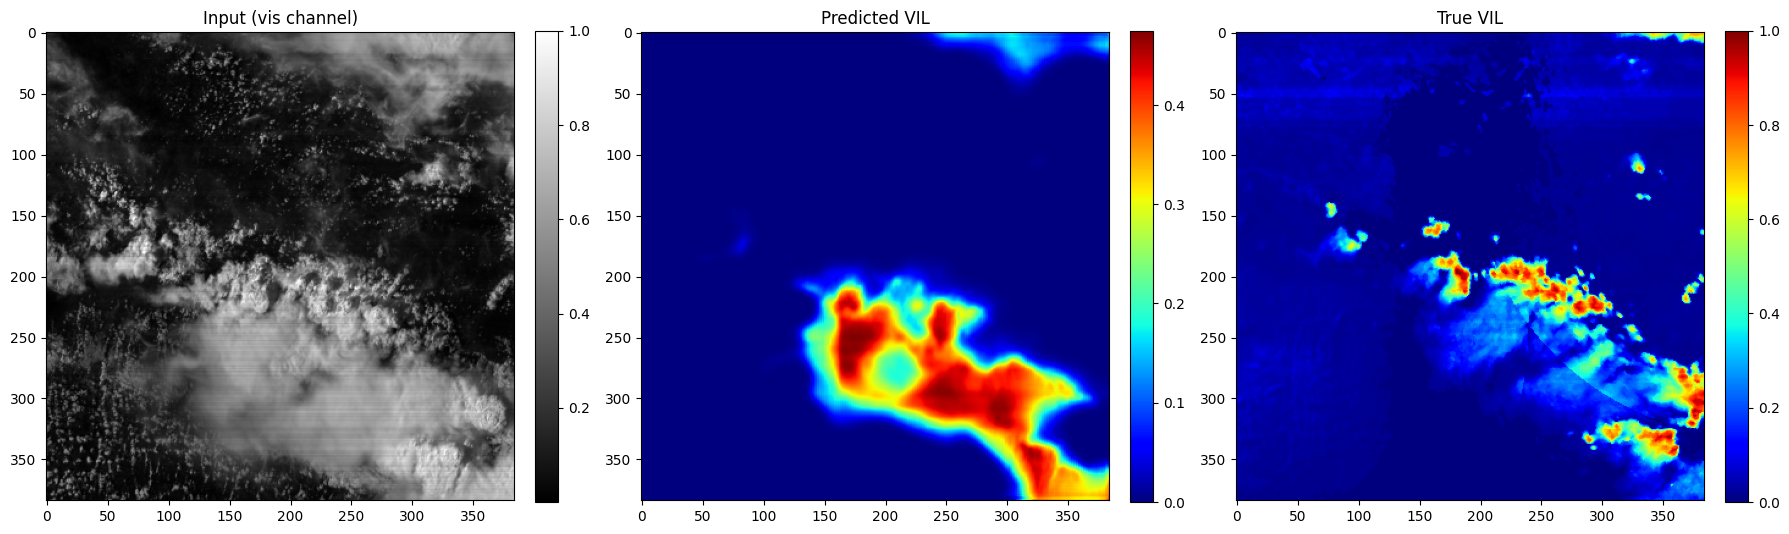

In [ ]:
def visualize_predictions(model, val_gen):
    X_batch, Y_batch = next(val_gen)
    pred_batch = model.predict(X_batch)

    # 随机选择一个样本进行可视化
    idx = np.random.randint(0, X_batch.shape[0])
    x_sample = X_batch[idx]
    y_true = Y_batch[idx]
    y_pred = pred_batch[idx]

    # 准备数据
    x_vis = x_sample[..., 0]  # 可见光通道
    y_true_2d = y_true[..., 0]
    y_pred_2d = y_pred[..., 0]

    # 创建图形
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 显示输入图像
    im0 = axes[0].imshow(x_vis, cmap='gray')
    axes[0].set_title("Input (vis channel)")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # 显示预测结果
    im1 = axes[1].imshow(y_pred_2d, cmap='jet')
    axes[1].set_title("Predicted VIL")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # 显示真实结果
    im2 = axes[2].imshow(y_true_2d, cmap='jet')
    axes[2].set_title("True VIL")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# 训练完成后可视化结果
visualize_predictions(model, val_gen)